# Aprendizaje Automatico - TP 1

In [1]:
%matplotlib inline

In [2]:
import os

In [181]:
import numpy as np
from scipy.sparse import coo_matrix
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:g}'.format
plt.rcParams['figure.figsize'] = 14, 5

In [4]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import BernoulliNB

from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [5]:
import features as cf
from util import *

C:\Software\Development\Anaconda2\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Cargamos el dataset, lo convertimos a un pandas DataFrame y separamos en set de entrenamiento y de test

In [6]:
# Por reproducibilidad, y para no perder tiempo armando el DataFrame cada vez, lo bajamos a
# un archivo la priemra vez que lo corrimos, ya seprando 20% para reportar como valor final
# de nuestro modelo
train_set_name = 'dataset/train_set.pkl'
test_set_name = 'dataset/test_set.pkl'
train_set = None
test_set = None

if os.path.isfile(train_set_name) and os.path.isfile(test_set_name):
    print 'Loading Train Set'
    train_set = print_time(lambda: joblib.load(train_set_name))
    print ''
        
    print 'Loading Test Set'
    test_set = print_time(lambda: joblib.load(test_set_name))
    print ''
else:
    train_set, test_set = load_raw_data()
    print ''
    
    print 'Saving Train Set'
    print_time(lambda: joblib.dump(train_set, train_set_name, compress=True))
    print ''
    
    print 'Saving Test Set'
    print_time(lambda: joblib.dump(test_set, test_set_name, compress=True))
    print ''

Loading Train Set
Done in 1.849000s

Loading Test Set
Done in 0.492000s



In [7]:
print_sets_summarys(train_set, test_set)

Train Set: 72000 samples - ham: 35997(0.50%) spam: 36003(0.50%)
Test Set:  18000 samples - ham: 9003(0.50%) spam: 8997(0.50%)


## Exploración de datos

Vamos a explorar un poco los datos. Primero inspeccionamos los primeros mails del set de entrenamiento, para ver que pinta tienen.

In [8]:
train_set.head()

,content_types,subject,body,label
0,[text/html],penny st0ck booms on continued demand,\r\n\r\n\r\n\r\n\r\npenny st0ck booms on conti...,spam
1,[text/plain],RE: BNP Paribas Master Netting Agreement,The receivables deal has been terminated. Feel...,ham
2,[text/plain],I NEED YOU TO ACT AS THE NEXT OF KIN TO LATE M...,"\n\n \n \nATTN:THE DIRECTOR /CEO,\n\nAN URGENT...",spam
3,[text/plain],WTI-Brent,Jeff -\nDon't know if WTI-Brent is on the new ...,ham
4,[text/plain],Mrs maureen clark,"\nDear Beloved in Christ,\n\nIt is by the grac...",spam


Ahora, generaremos la matriz de atributos (unigramas y bigramas) TF-IDF sobre el cuerpo de los mails, y usando dos técnicas de selección de atributos, visualizaremos los 2 atributos más importantes. Las técnicas son:
    - Elegir los 2 atributos que son mas probables(segun un test chi2) que sean dependientes de la etiqueta
    - Entrenar un clasificador SVM lineal con penalización L1(fuerza esparcidad, gran cantidad de pesos en 0), y elegir los 2 atributos que mas importancia tengan
Para visualizar, mostramos un gráfico con el valor de cada uno de los 2 atributos en los ejes, y la clase como color. Tambien mostramos un histograma para cada uno de estos 2 atributos, agrupando por la clase.

In [71]:
def plot_2_best_features(feature_selector_type, tokens, token_names, labels):
    if feature_selector_type == 'k_best':
        transformer = SelectKBest(chi2, k=2)
        selected_tokens = transformer.fit_transform(tokens, labels)
        feature1_name, feature2_name = [token_names[i] for i in transformer.get_support(indices=True)]
    elif feature_selector_type == 'l1':
        svc = LinearSVC(penalty="l1", dual=False).fit(tokens, labels)
        ind = np.argpartition(svc.coef_[0], -2)[-2:]
        ind = ind[np.argsort(svc.coef_[0, ind])][::-1]
        selected_tokens = tokens[:, ind]
        feature1_name, feature2_name = [token_names[i] for i in ind]
    else:
        raise ValueError('Invalid feature_selector_type. Expected \'k_best\' or \'l1\'')

    title = 'Features selected using %s' % feature_selector_type
    
    df = pd.DataFrame(selected_tokens.todense(), columns=[feature1_name, feature2_name])
    df['label'] = labels
    
    df.plot(kind='scatter',
            x=feature1_name,
            y=feature2_name,
            figsize=(10, 5),
            title=title,
            c=['blue' if label == 'ham' else 'red' for label in labels])
    
    fig, axs = plt.subplots(ncols=2)
    title = 'Feature \'%s\' frequency by classs'
    
    df.groupby('label')[feature1_name].plot(kind='hist',
                                            ax=axs[0],
                                            title=title % feature1_name,
                                            legend=True, alpha=0.4)
    df.groupby('label')[feature2_name].plot(kind='hist',
                                            ax=axs[1],
                                            title=title % feature2_name,
                                            legend=True, alpha=0.4)
    

def show_selectors_bests_features(X):
    tfidf = TfidfVectorizer(stop_words='english',
                                    ngram_range=(1, 2),
                                    strip_accents='ascii',
                                    sublinear_tf=True)
    tokens = tfidf.fit_transform(X.body)
    token_names = tfidf.get_feature_names()
    plot_2_best_features('k_best', tokens, token_names, X.label)
    plot_2_best_features('l1', tokens, token_names, X.label)

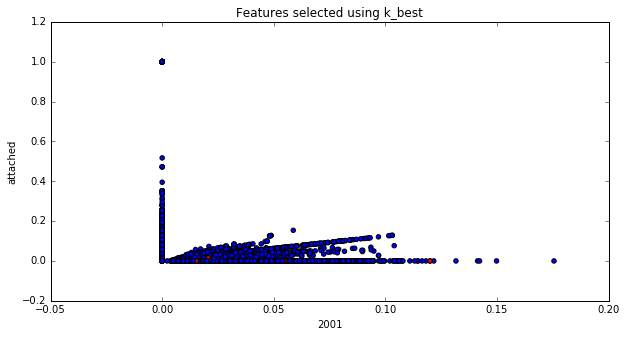

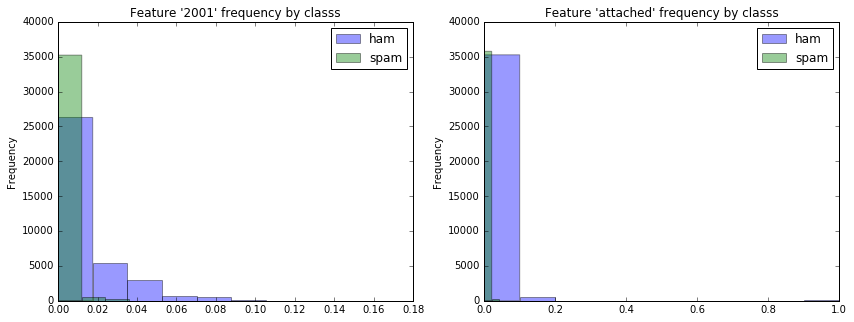

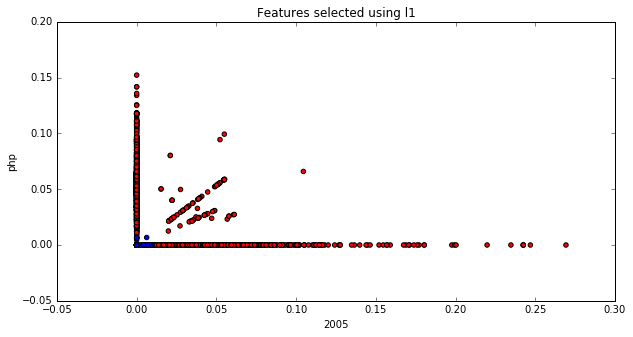

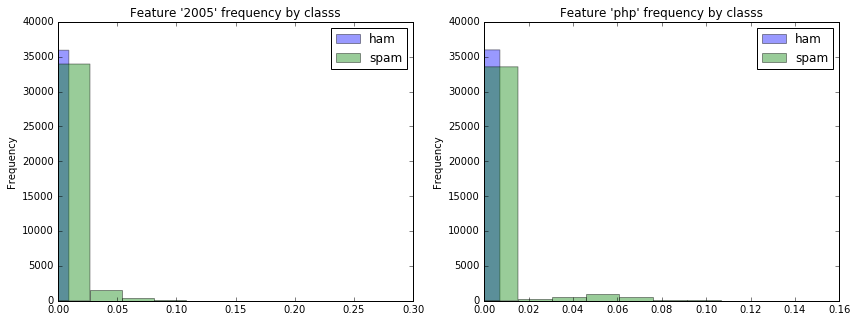

In [72]:
show_selectors_bests_features(train_set)

### TODO: Alguna conclusión sobre lo que estos graficos nos dicen

## Atributos

Definimos los siguientes atributos a ser extraidos de cada mail:
1. Atributos simples:
    - Longitud del asunto
    - Cantidad de espacios en el asunto dividido por la longitud del asunto
    - Cantidad de caracteres mayusculas en el asunto dividido por la longitud del asunto
    - Longitud del cuerpo
    - Cantidad de espacios en el cuerpo dividido por la longitud del cuerpo
    - Cantidad de caracteres mayusculas en el cuerpo dividido por la longitud del cuerpo
    - Cantidad de oraciones del cuerpo
    - Tiene el mail contenido HTML?
    - Tiene el mail imágenes?
2. Atributos de vectorizacion del asunto: cantidad de apariciones por token dividido por la cantidad de documentos en los que aparece(TF-IDF)
3. Atributos de vectorizacion del cuerpo: cantidad de apariciones por token dividido por la cantidad de documentos en los que aparece(TF-IDF)

In [10]:
def build_simple_extractors():
    return ('simple_features', cf.SimpleFeaturesExtractor([('subject_length', cf.subject_length), 
        ('subject_spaces', cf.subject_spaces), 
        ('subject_caps', cf.subject_caps),
        ('body_length', cf.body_length), 
        ('body_spaces', cf.body_spaces), 
        ('body_caps', cf.body_caps), 
        ('body_sentences', cf.body_sentences),
        ('has_html', cf.has_html), 
        ('has_image', cf.has_image)
      ]))

def build_vectorizer_extractor(**kwargs):
    return ('tfidf', TfidfVectorizer(stop_words='english', strip_accents='ascii', sublinear_tf=True, **kwargs))

## Reducción de dimensionalidad

Utilizaremos las técnicas de selección de atributos mencionadas en la sección de exploración de datos, y también agregaremos el método de Analisis de Componentes Principales para reducción de dimensionalidad.

In [11]:
def build_dimensionality_reductor(reductor_type, **kwargs):
    if reductor_type is None:
        return None
    elif reductor_type == 'k_best':
        return ('k_best', SelectKBest(chi2, **kwargs))
    elif reductor_type == 'l1':
        return ('l1', SelectFromModel(**kwargs))
    elif reductor_type == 'pca':
        return ('pca', TruncatedSVD(**kwargs))

In [12]:
def build_subject_pipeline(pipeline_type):
    pipeline = [('selector', ColumnSelectorExtractor('subject'))]
    if pipeline_type == 'tfidf':
        pipeline.append(build_vectorizer_extractor(ngram_range=(1, 2), min_df=0.001, max_df=0.7))
    else:
        pipeline.append(build_vectorizer_extractor(ngram_range=(1, 2), min_df=0.0001, max_df=0.95))

        if pipeline_type == 'k_best':
            pipeline.append(build_dimensionality_reductor(pipeline_type, k=20))
        elif pipeline_type == 'l1':
            pipeline.append(build_dimensionality_reductor(pipeline_type, estimator=LinearSVC(penalty="l1", dual=False, C=1.0)))
        elif pipeline_type == 'pca':
            pipeline.append(build_dimensionality_reductor(pipeline_type, n_components=20))
        else:
            return None
    return ('subject', Pipeline(pipeline))

def build_body_pipeline(pipeline_type):
    pipeline = [('selector', ColumnSelectorExtractor('body'))]
    if pipeline_type == 'tfidf':
        pipeline.append(build_vectorizer_extractor(ngram_range=(1, 1), min_df=0.001, max_df=0.7))
    else:
        pipeline.append(build_vectorizer_extractor(ngram_range=(1, 1), min_df=0.0001, max_df=0.95))

        if pipeline_type == 'k_best':
            pipeline.append(build_dimensionality_reductor(pipeline_type,  k=50))
        elif pipeline_type == 'l1':
            pipeline.append(build_dimensionality_reductor(pipeline_type, estimator=LinearSVC(penalty="l1", dual=False, C=5.0)))
        elif pipeline_type == 'pca':
            pipeline.append(build_dimensionality_reductor(pipeline_type, n_components=50))
        else:
            return None
    return ('body', Pipeline(pipeline))

## Modelos

Los algoritmos de aprendizaje para clasificación con los que probaremos son:
### TODO: Completar con los clasificadores
Explicar que corrimos todo con 10K samples y vimos que knn, svm y multinomial_nb no garpan


In [13]:
def build_classifier(classifier_type, **kwargs):
    classifier_dict = {'dt': DecisionTreeClassifier(**kwargs),
                  'random_forest': RandomForestClassifier(**kwargs), 
                  'bernoulli_nb': BernoulliNB(**kwargs)}
    
    if not classifier_type in classifier_dict:
        return None
    
    return (classifier_type, classifier_dict[classifier_type])

## Ejecución y puntuación de cada pipeline

### TODO: Completar con un texto
Ahora vamos a correr todos los modelos posibles que tienen sentido...

In [36]:
def build_pipeline(simple_features=True, subject_pipeline_type=None, body_pipeline_type=None, classifier_type=None):
    extractors = []
    names = []
    
    if simple_features:
        # Extractor de atributos simples
        extractors.append(build_simple_extractors())
        names.append('simple_features')

    if subject_pipeline_type is not None:
        # Pipeline para extraer atributos de vectorizacion del asunto del mail
        extractors.append(build_subject_pipeline(subject_pipeline_type))
        names.append('subject_%s' % subject_pipeline_type)
        
    if body_pipeline_type is not None:
        # Pipeline para extraer atributos de vectorizacion del cuerpo del mail
        extractors.append(build_body_pipeline(body_pipeline_type))
        names.append('body_%s' % body_pipeline_type)

    extractors_count = len(extractors)
    if extractors_count == 0:
        return None

    if classifier_type is not None:
        # Usamos FeatureUnion para combinar los distintos extractores de atributos
        names.append(classifier_type)
        return '__'.join(names), Pipeline([('feature_extractors', FeatureUnion(extractors)), build_classifier(classifier_type)])
    else:
        return None

def build_all_pipelines():
    classifier_types = ['dt', 'random_forest', 'bernoulli_nb']
    pipelines = []
    for simple_features in [True, False]:
        for subject_pipeline_type in [None, 'tfidf', 'k_best', 'l1', 'pca']:
            for body_pipeline_type in [None, 'tfidf', 'k_best', 'l1', 'pca']:
                for classifier_type in classifier_types:
                    pipeline_tuple = build_pipeline(simple_features=simple_features,
                                         subject_pipeline_type=subject_pipeline_type,
                                         body_pipeline_type=body_pipeline_type,
                                         classifier_type=classifier_type)
                    if pipeline_tuple is not None:
                        pipelines.append(pipeline_tuple)
    
    return pipelines

In [37]:
def evaluate_and_meassure(X, cv=10, n_jobs=1, verbose=0, force_run=False):
    if not os.path.exists('results'):
        os.makedirs('results')
        
    scores_name = 'results/scores_full.pkl'
    cv_times_name = 'results/cv_times_full.pkl'
    
    pipelines = build_all_pipelines()
    
    scores = {}
    cv_times = {}

    if not force_run and os.path.isfile(scores_name):
        print 'Loading previous scores'
        scores = print_time(lambda: joblib.load(scores_name))
    
    if not force_run and os.path.isfile(cv_times_name):
        print 'Loading previous cv_times'
        cv_times = print_time(lambda: joblib.load(cv_times_name))

    print ''

    i = 0
    pipelines_count = len(pipelines)

    for name, pipeline in pipelines:
        i = i + 1
        if name in scores:
            print 'Loaded from previous run %d-Fold CV for pipeline %s(%d/%d)' % (cv, name, i, pipelines_count)
            model_scores = scores[name]
            model_cv_time = cv_times[name]
        else:
            print 'Running %d-Fold CV for pipeline %s(%d/%d)' % (cv, name, i, pipelines_count)
            model_scores, model_cv_time = measure_time(lambda: cross_val_score(pipeline, X, X.label, cv=cv, n_jobs=n_jobs, verbose=verbose))
            print 'Done in %fs' % model_cv_time
            scores[name] = model_scores
            cv_times[name] = model_cv_time           

        print 'CV scores mean: %f std: %f' % (np.mean(model_scores), np.std(model_scores))
        joblib.dump(scores, scores_name, compress=True)
        joblib.dump(cv_times, cv_times_name, compress=True)
        print ''

    return pipelines, scores, cv_times

In [38]:
pipelines, scores, cv_times = evaluate_and_meassure(train_set, cv=10, n_jobs=5)

In [52]:
scores = joblib.load('results/scores_full.pkl')
cv_times = joblib.load('results/cv_times_full.pkl')

### TODO: Visualizaciones (usando DataFrame?) de los resultados, tanto puntajes de CV como runtimes

## Evaluacion del mejor pipeline en el set de test

Por último vamos a reportar el desempeño del mejor pipeline elegido con CV, en un set de datos limpio.
### TODO: elegir el mejor modelo de todos los que corrimos

In [155]:
mean_scores_list = [(name, np.mean(model_scores)) for name, model_scores in scores.iteritems()]
mean_scores_list[np.argmax(map(lambda x: x[1], mean_scores_list))]

('simple_features__subject_tfidf__body_l1__random_forest', 0.98698605694497932)

In [59]:
best_model_name, best_model = build_pipeline(True, 'tfidf', 'l1', 'random_forest')

In [60]:
def model_evaluation(pipeline, name, X_train, X_test):
    print 'Training pipeline %s in the train set' % name
    print_time(lambda: pipeline.fit(X_train, X_train.label))

    print 'Classifying test set with pipeline %s' % name
    pred = print_time(lambda: pipeline.predict(X_test))

    print 'Accuracy: %f' % accuracy_score(X_test.label, pred)
    print 'Classification report:'
    print classification_report(X_test.label, pred, target_names=['ham', 'spam'])
    print 'Confusion matrix:'
    print pd.crosstab(X_test.label, pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [62]:
model_evaluation(best_model, best_model_name, train_set, test_set)

Training pipeline simple_features__subject_tfidf__body_l1__random_forest in the train set
Done in 129.516000s
Classifying test set with pipeline simple_features__subject_tfidf__body_l1__random_forest
Done in 27.085000s
Accuracy: 0.986500
Classification report:
             precision    recall  f1-score   support

        ham       0.98      0.99      0.99      9003
       spam       0.99      0.98      0.99      8997

avg / total       0.99      0.99      0.99     18000

Confusion matrix:
Predicted   ham  spam    All
True                        
ham        8918    85   9003
spam        158  8839   8997
All        9076  8924  18000


Guardamos este modelo para utilizarlo posteriormente en un programa separado

In [63]:
print 'Training pipeline %s in the full dataset' % best_model_name
_ = print_time(lambda: best_model.fit(train_set.append(test_set), train_set.append(test_set).label))

Training pipeline simple_features__subject_tfidf__body_l1__random_forest in the full dataset
Done in 177.498000s


In [64]:
save_model('best_model', 'results', best_model)

Saving model best_model to disk
Done in 6.440000s
Saved at results/best_model.pkl


## Exploración de atributos mas importantes

In [151]:
extractors = best_model.named_steps['feature_extractors']
simple_extractors = extractors.transformer_list[0][1]
subject_extractors = extractors.transformer_list[1][1]
subject_tfidf = subject_extractors.named_steps['tfidf']
body_extractors = extractors.transformer_list[2][1]
body_tfidf = body_extractors.named_steps['tfidf']
body_l1 = body_extractors.named_steps['l1']
rf = best_model.named_steps['random_forest']

feature_names = []
feature_names += [ 'simple_features_' + name  for name in simple_extractors.get_feature_names() ]
feature_names += [ 'subject_tfidf_' + name  for name in subject_tfidf.get_feature_names() ]
feature_names += [ 'body_l1_' + name  for name in body_l1.transform([body_tfidf.get_feature_names()])[0] ]
feature_names = np.asarray(feature_names)

In [197]:
extracted = extractors.transform(train_set)

In [198]:
top_features_indexs = np.argsort(rf.feature_importances_)[::-1][0:10]
top_features_importances = rf.feature_importances_[top_features_indexs]
top_feature_names = feature_names[top_features_indexs]
top_features = pd.DataFrame(extracted[:, top_features_indexs].todense(), columns=top_feature_names)
top_features['label'] = train_set.label

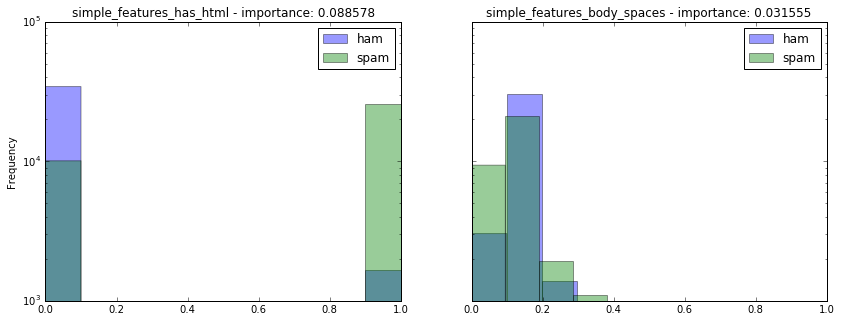

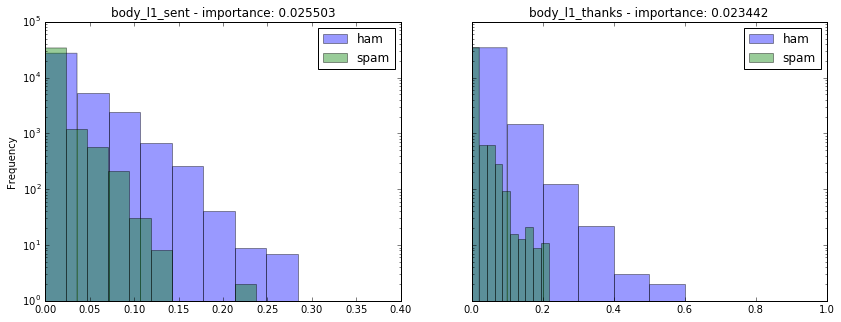

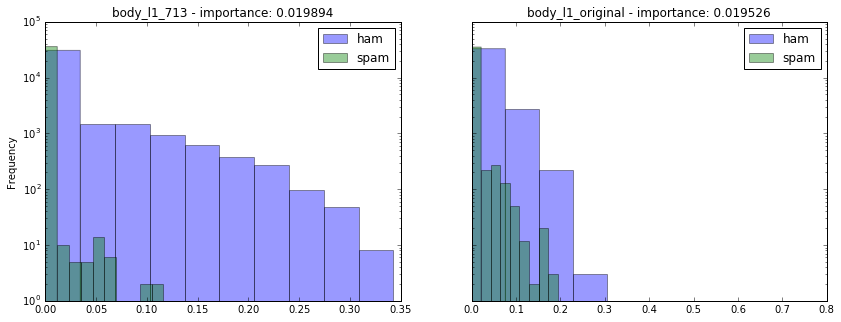

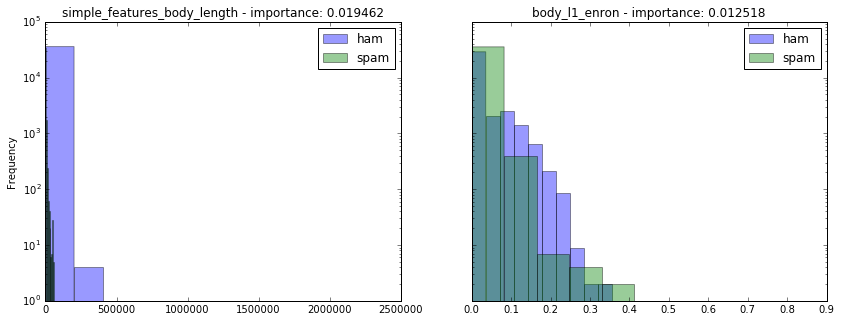

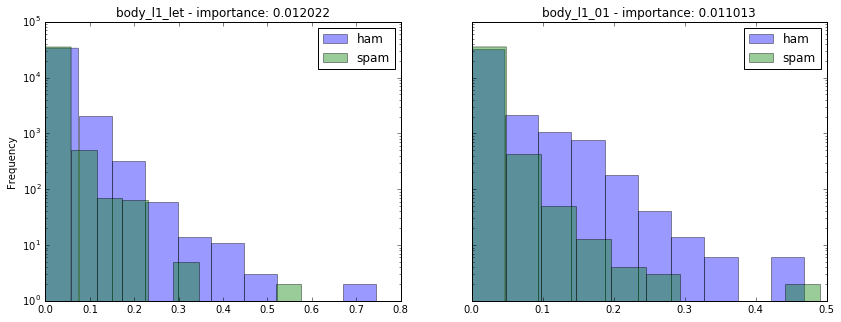

In [199]:
for i in range(10):
    if i % 2 == 0:
        fig, axs = plt.subplots(ncols=2, sharey=True)
        axs[0].set_yscale('log')
        axs[1].set_yscale('log')
    top_features.groupby('label')[top_feature_names[i]].plot(kind='hist',
                                            title=top_feature_names[i] + ' - importance: %f' % top_features_importances[i],
                                            ax=axs[i % 2],
                                            legend=True, alpha=0.4)
    

## Conclusiones

### TODO: Escribir conclusiones